In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

openmc.config["cross_sections"] = (
    "/home/lucas/Proyecto_Integrador/endfb-viii.0-hdf5/cross_sections.xml"
)

Atributos

In [2]:
vacio = False
# source_file = "/home/lucas/Proyecto_Integrador/Proyecto_Integrador/creado.h5"
source_file = '../surface_source.h5'

L_x = 30  # cm dx del paralelepipedo
L_y = 30  # cm dy del paralelepipedo
L_z = 15  # cm

L_x_vacio = 8  # cm dx del vacio
L_y_vacio = 8  # cm dy del vacio

z_min = 5 - 1e-6  # cm

Defino materiales

In [3]:
mat_agua = openmc.Material()
mat_agua.add_nuclide("H1", 2.0, "ao")
mat_agua.add_nuclide("O16", 1.0, "ao")
mat_agua.add_s_alpha_beta("c_H_in_H2O")
mat_agua.set_density("g/cm3", 1)

mats = openmc.Materials([mat_agua])
mats.export_to_xml()

Defino la geometria

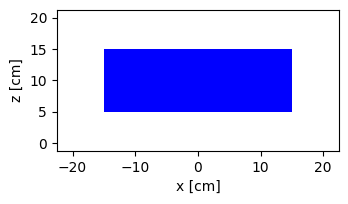

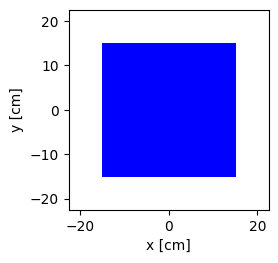

In [4]:
prll = openmc.model.RectangularParallelepiped(
    -L_x / 2, L_x / 2, -L_y / 2, L_y / 2, z_min, L_z, boundary_type="vacuum"
)

prll_vacio = openmc.model.RectangularParallelepiped(
    -L_x_vacio / 2,
    L_x_vacio / 2,
    -L_y_vacio / 2,
    L_y_vacio / 2,
    z_min,
    L_z,
    boundary_type="transmission",
)

if vacio:
    cell_h2o = openmc.Cell(region=-prll & +prll_vacio, fill=mat_agua)
    cell_vacio = openmc.Cell(region=-prll_vacio, fill=None)

    univ = openmc.Universe(cells=[cell_h2o, cell_vacio])

    univ.plot(
        width=(1.5 * L_x, 1.5 * L_z),
        basis="xz",
        colors=(
            {
                cell_h2o: "blue",
                cell_vacio: "yellow",
            }
        ),
    )
    univ.plot(
        width=(1.5 * L_x, 1.5 * L_x),
        basis="xy",
        colors=(
            {
                cell_h2o: "blue",
                cell_vacio: "yellow",
            }
        ),
    )
else:
    cell_h2o = openmc.Cell(region=-prll, fill=mat_agua)

    univ = openmc.Universe(cells=[cell_h2o])

    univ.plot(
        width=(1.5 * L_x, 1.5 * L_z),
        basis="xz",
        colors=({cell_h2o: "blue"}),
    )
    univ.plot(
        width=(1.5 * L_x, 1.5 * L_x),
        basis="xy",
        colors=({cell_h2o: "blue"}),
    )

geom = openmc.Geometry(univ)
geom.export_to_xml()

Defino la fuente superficial y los parametros de la simulacion

In [5]:
settings = openmc.Settings()
settings.run_mode = "fixed source"
settings.particles = int(5100162/40)
settings.batches = 40
settings.source = openmc.FileSource(source_file)
settings.export_to_xml()

Defino tallies

In [6]:
# Initialize an empty tallies object
tallies = openmc.Tallies()

# Create a mesh of the parallelepiped to tally current
mesh_current = openmc.RectilinearMesh()
mesh_current.x_grid = np.linspace(-L_x / 2, L_x / 2, L_x * 4 + 1)
mesh_current.y_grid = np.linspace(-L_y / 2, L_y / 2, L_y * 4 + 1)
mesh_current.z_grid = np.linspace(0, L_z, L_z * 4 + 1)

# Create mesh filter to tally current
mesh_surface_filter = openmc.MeshSurfaceFilter(mesh_current)
mesh_surface_tally = openmc.Tally(name="current")
mesh_surface_tally.filters = [mesh_surface_filter]
mesh_surface_tally.scores = ["current"]
tallies.append(mesh_surface_tally)

# Create a mesh of the parallelepiped to tally flux
mesh_flux = openmc.RectilinearMesh()
mesh_flux.x_grid = np.linspace(-L_x / 2, L_x / 2, L_x * 4 + 1)
mesh_flux.y_grid = np.linspace(-0.1, 0.1, 2)
mesh_flux.z_grid = np.linspace(0, L_z, L_z * 4 + 1)

# Create mesh filter to tally flux
mesh_flux_filter = openmc.MeshFilter(mesh_flux)
mesh_flux_tally = openmc.Tally(name="flux")
mesh_flux_tally.filters = [mesh_flux_filter]
mesh_flux_tally.scores = ["flux"]
tallies.append(mesh_flux_tally)

# Create a mesh of the parallelepiped to tally flux
mesh_flux = openmc.RectilinearMesh()
mesh_flux.x_grid = np.linspace(-L_x / 2, L_x / 2, 2)
mesh_flux.y_grid = np.linspace(-L_y/2, L_y/2, 2)
mesh_flux.z_grid = np.linspace(0, L_z, L_z * 4 + 1)

# Create mesh filter to tally flux
mesh_flux_filter = openmc.MeshFilter(mesh_flux)
mesh_flux_tally = openmc.Tally(name="flux2")
mesh_flux_tally.filters = [mesh_flux_filter]
mesh_flux_tally.scores = ["flux"]
tallies.append(mesh_flux_tally)

# Print tallies
print(tallies)

# Export to "tallies.xml"
tallies.export_to_xml()

[Tally
	ID             =	1
	Name           =	current
	Filters        =	MeshSurfaceFilter
	Nuclides       =	
	Scores         =	['current']
	Estimator      =	None
	Multiply dens. =	True, Tally
	ID             =	2
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	
	Scores         =	['flux']
	Estimator      =	None
	Multiply dens. =	True, Tally
	ID             =	3
	Name           =	flux2
	Filters        =	MeshFilter
	Nuclides       =	
	Scores         =	['flux']
	Estimator      =	None
	Multiply dens. =	True]


Corro la simulacion

In [7]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################